# ***Importing Necessary libraries***

In [ ]:
!pip install tensorflow

import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave
import tensorflow as tf
import os

from sklearn.preprocessing import MinMaxScaler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### ***Custom Image Data Generator (To create the batches)***

In [ ]:
def load_img(img_dir, img_list):

    images=[]
    ground_truth_list = []

    for i, image_name in enumerate(img_list):

        if (image_name.split('.')[1] == 'npz'):

            image_file_path = os.path.join(img_dir,image_name)

            MRI_image = np.load(image_file_path)

            image = MRI_image['a']

            #image = np.transpose(MRI_image['a'],(1,2,0))          No need to transpose

            #images.append(image[56:184, 56:184])

            images.append(image)

            image_ground_truth = MRI_image['b'].astype(np.uint8)

            #image_ground_truth = image_ground_truth[56:184, 56:184]

            #n_classes = len(np.unique(image_ground_truth))           not all images have all 10 classes labels so only going to take 10 as total classes

            n_classes = 10

            image_ground_truth = to_categorical(image_ground_truth, num_classes=n_classes)

            ground_truth_list.append(image_ground_truth)

            pass

        pass


    images = np.array(images)
    ground_truth_list = np.array(ground_truth_list)

    return(images,ground_truth_list)


def imageLoader(img_dir, img_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)

            X , Y = load_img(img_dir, img_list[batch_start:limit])


            yield (X,Y) #a tuple with two numpy arrays with batch_size samples

            batch_start += batch_size
            batch_end += batch_size

In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
print("Number of GPUs available : ", len(tf.config.list_physical_devices('GPU')))

tf.test.gpu_device_name()

Number of GPUs available :  0


''


(256, 256, 103)

(256, 256)
[[0.35160333 0.23435513 0.26232519 ... 0.41065122 0.39850261 0.34016104]
 [0.09167962 0.05565758 0.05961294 ... 0.34863681 0.35923153 0.39963272]
 [0.23760418 0.1895748  0.19805057 ... 0.42647267 0.43198192 0.4088148 ]
 ...
 [0.29792344 0.31077836 0.32038424 ... 0.35555869 0.36403447 0.386354  ]
 [0.2607713  0.23958186 0.28266704 ... 0.31346235 0.29778217 0.33168527]
 [0.2805481  0.27475632 0.29481565 ... 0.32349202 0.32674107 0.31925413]]


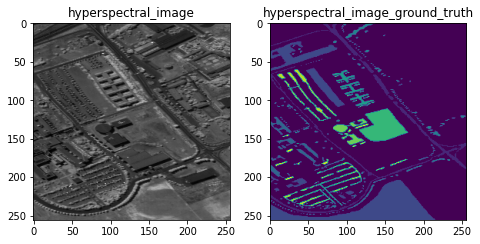

In [ ]:
scaler = MinMaxScaler()


npz_files_folder_path = '/content/drive/MyDrive/pavia_Hyperspectral_images/'

hyperspectral_image_npz = 'PaviaU_scene_11.npz'

image_file_path = os.path.join(npz_files_folder_path, hyperspectral_image_npz)


hyperspectral_image_np_zip = np.load(image_file_path)

hyperspectral_image = hyperspectral_image_np_zip['a']

hyperspectral_image_ground_truth = hyperspectral_image_np_zip['b'].astype(np.uint8)

#image normalization using MinMax scaler

hyperspectral_image=scaler.fit_transform(hyperspectral_image.reshape(-1, hyperspectral_image.shape[-1])).reshape(hyperspectral_image.shape)


print()

print(hyperspectral_image.shape)

print()

print(hyperspectral_image_ground_truth.shape)


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('hyperspectral_image')
plt.imshow(hyperspectral_image[:,:,100], cmap='gray')
plt.subplot(232)
plt.title('hyperspectral_image_ground_truth')
plt.imshow(hyperspectral_image_ground_truth)

print(hyperspectral_image[:,:,100])


In [ ]:
batch_size = 4

npz_files_folder_path = '/content/drive/MyDrive/pavia_Hyperspectral_images/'

file_name = 'PaviaU_scene_10.npz'

file_2 = 'PaviaU_scene_11.npz'

file_3 = 'PaviaU_scene_8.npz'

file_4 = 'PaviaU_scene_9.npz'

file_name_list = []

file_name_list.append(file_name)

file_name_list.append(file_2)

file_name_list.append(file_3)

file_name_list.append(file_4)


train_images_dataGenerator = imageLoader(img_dir=npz_files_folder_path,img_list=file_name_list,batch_size=batch_size)

X, Y = train_images_dataGenerator.__next__()

(4, 256, 256, 103)

(4, 256, 256, 10)


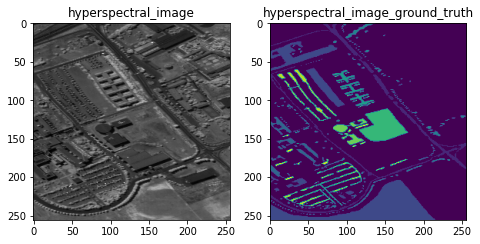

In [ ]:
print(X.shape)
print()

print(Y.shape)


sample_hyperspectral_image = X[3]

sample_ground_truth = Y[3]

#converting to categorical ground truth back to normal ground truth

sample_ground_truth=np.argmax(sample_ground_truth, axis=2)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('hyperspectral_image')
plt.imshow(sample_hyperspectral_image[:,:,100], cmap='gray')
plt.subplot(232)
plt.title('hyperspectral_image_ground_truth')
plt.imshow(sample_ground_truth)



### ***Defining UNET Model***

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

In [ ]:
################################################################
def multi_unet_model(n_classes=10, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=103):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    #model.summary()

    return model

### ***Training of UNET Model on Pavia hyperspectral Images***

**Model Compilation and Getting images data ready**

In [ ]:

#Update batch size to vary image batches

batch_size = 1

validation_batch_size = 1

training_npz_folder_path = '/content/drive/MyDrive/pavia_Hyperspectral_images/'

training_npz_files_list = os.listdir(training_npz_folder_path)


validation_npz_folder_path = '/content/drive/MyDrive/pavia_Hyperspectral_images/'

validation_npz_files_list = os.listdir(validation_npz_folder_path)

print(validation_npz_files_list)




train_images_dataGenerator = imageLoader(img_dir=training_npz_folder_path,img_list=training_npz_files_list,batch_size=batch_size)


validation_images_dataGenerator = imageLoader(img_dir=validation_npz_folder_path,img_list=validation_npz_files_list,batch_size=validation_batch_size)


X, Y = train_images_dataGenerator.__next__()

print(X.shape)
print(Y.shape)

print()

steps_per_epoch = len(training_npz_files_list)//batch_size
val_steps_per_epoch = len(validation_npz_files_list)//batch_size

print(steps_per_epoch)

model = multi_unet_model(n_classes=10,IMG_HEIGHT=256,IMG_WIDTH=256,IMG_CHANNELS=103)

#model.compile(optimizer = optim, loss=total_loss, metrics=metrics)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())

print(model.input_shape)
print(model.output_shape)

print("----------")
print(Y.shape)
print("----------")


# Hyperspectral image NORMALIZATION using MinMax scaler
# Comment these lines after normalizing whole IP and Pavia dataset images
New_X = []
for sample in X:

  ######################################### copy this function for noralization #########################################

  sample=scaler.fit_transform(sample.reshape(-1, sample.shape[-1])).reshape(sample.shape)

  New_X.append(sample)

  pass

X = np.array(New_X)

print(X.shape)

print()
#print(X[0,:,:,:])

['PaviaU_scene_8.npz']
(1, 256, 256, 103)
(1, 256, 256, 10)

1
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                03)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  14848       ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                               

In [ ]:
history=model.fit(train_images_dataGenerator,
          steps_per_epoch=steps_per_epoch,
          epochs=2000,
          verbose=1,
          validation_data=(validation_images_dataGenerator),
          validation_steps=val_steps_per_epoch,
          )

model.save('/content/drive/MyDrive/pavia_unet.hdf5')

Epoch 1/1000
1/1 [==============================] - 3s 3s/step - loss: 1071.4910 - accuracy: 0.0223
Epoch 2/1000
1/1 [==============================] - 1s 1s/step - loss: 273.5660 - accuracy: 0.0254
Epoch 3/1000
1/1 [==============================] - 1s 1s/step - loss: 155.2015 - accuracy: 0.0234
Epoch 4/1000
1/1 [==============================] - 1s 1s/step - loss: 95.2233 - accuracy: 0.0230
Epoch 5/1000
1/1 [==============================] - 1s 1s/step - loss: 71.0303 - accuracy: 0.0235
Epoch 6/1000
1/1 [==============================] - 1s 1s/step - loss: 56.1913 - accuracy: 0.0283
Epoch 7/1000
1/1 [==============================] - 1s 1s/step - loss: 46.0206 - accuracy: 0.0320
Epoch 8/1000
1/1 [==============================] - 1s 1s/step - loss: 36.5891 - accuracy: 0.0382
Epoch 9/1000
1/1 [==============================] - 1s 1s/step - loss: 29.1813 - accuracy: 0.0412
Epoch 10/1000
1/1 [==============================] - 1s 1s/step - loss: 23.4815 - accuracy: 0.0407
Epoch 11/1000
1

**Loss and accuracy graphs**

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

KeyError: ignored

**plotting predction**


(256, 256, 103)
(1, 256, 256, 103)
(1, 256, 256, 10)
(256, 256)
-----
(256, 256, 10)


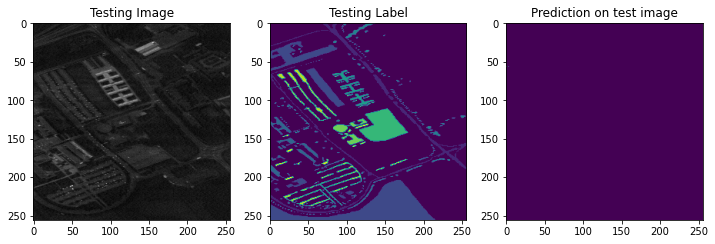

[0 1 4]


In [ ]:
#################################################
from keras.models import load_model

my_model = load_model('/content/drive/MyDrive/pavia_unet.hdf5')

print(my_model)

print()

npz_files_folder_path = '/content/drive/MyDrive/pavia_Hyperspectral_images/'

file_name_list = os.listdir(npz_files_folder_path)

X, Y = load_img(img_dir=npz_files_folder_path,img_list=file_name_list)

query_hyperspectral_image = X[0]

print(query_hyperspectral_image.shape)

test_img_input = np.expand_dims(query_hyperspectral_image, axis=0)

print(test_img_input.shape)

#Prediction of UNET model

test_prediction = my_model.predict(test_img_input)

print(test_prediction.shape)

#converting prediction to normal from to categorial i.e   (256 x 256 x 10) ==> (256 x 256 x 1)

test_prediction_argmax=np.argmax(test_prediction, axis=3)[0,:,:]

print(test_prediction_argmax.shape)

prediction = test_prediction_argmax


ground_truth = Y[0]


print("-----")

#ground_truth = np.expand_dims(ground_truth, axis=2)

print(ground_truth.shape)


ground_truth=np.argmax(ground_truth, axis=2)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(query_hyperspectral_image[:,:,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction[:,:])
plt.show()

print(np.unique(prediction))